In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

In [22]:
#Read in the cleaned data
housing_data = pd.read_csv("Clean_Data/mls_condo_cleaned.csv")
housing_data.head()

,Mortgage Rates,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking,Lat,Lon,Cluster
0,2.65,2358250,Elon,27244,3,2,1166,1,1986,2020-12-17,2021-01-07,180000,197500,21,17500,36.1029,-79.5067,0
1,2.65,2202465,Raleigh,27601,2,2,1251,1,2018,2018-07-09,2021-01-08,575500,587702,914,12202,35.7727,-78.6324,1
2,2.65,2170728,Raleigh,27601,2,2,1251,1,2018,2018-02-01,2021-01-08,535000,543546,1072,8546,35.7727,-78.6324,1
3,2.65,2175010,Cary,27511,2,2,1631,1,2019,2018-02-25,2021-01-05,450000,455904,1045,5904,35.7641,-78.7786,1
4,2.65,2355989,Raleigh,27609,2,2,942,1,1972,2020-12-02,2021-01-07,120000,125200,36,5200,35.8480,-78.6317,3


In [23]:
# Convert date columns to datetime
housing_data['List Date'] = pd.to_datetime(housing_data['List Date'])
housing_data['Closing Date'] = pd.to_datetime(housing_data['Closing Date'])

In [24]:
# Extracting year and month from List Date and Closing Date
housing_data['List Year'] = housing_data['List Date'].dt.year
housing_data['List Month'] = housing_data['List Date'].dt.month
housing_data['Closing Year'] = housing_data['Closing Date'].dt.year
housing_data['Closing Month'] = housing_data['Closing Date'].dt.month

housing_data.head()

,Mortgage Rates,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,...,Sold Price,Days on Market,Over Asking,Lat,Lon,Cluster,List Year,List Month,Closing Year,Closing Month
0,2.65,2358250,Elon,27244,3,2,1166,1,1986,2020-12-17,...,197500,21,17500,36.1029,-79.5067,0,2020,12,2021,1
1,2.65,2202465,Raleigh,27601,2,2,1251,1,2018,2018-07-09,...,587702,914,12202,35.7727,-78.6324,1,2018,7,2021,1
2,2.65,2170728,Raleigh,27601,2,2,1251,1,2018,2018-02-01,...,543546,1072,8546,35.7727,-78.6324,1,2018,2,2021,1
3,2.65,2175010,Cary,27511,2,2,1631,1,2019,2018-02-25,...,455904,1045,5904,35.7641,-78.7786,1,2018,2,2021,1
4,2.65,2355989,Raleigh,27609,2,2,942,1,1972,2020-12-02,...,125200,36,5200,35.8480,-78.6317,3,2020,12,2021,1


In [25]:
# Handling outliers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

for col in ['List Price', 'Sold Price', 'SqFt', 'Days on Market']:
    handle_outliers(housing_data, col)

housing_data.head()

,Mortgage Rates,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,...,Sold Price,Days on Market,Over Asking,Lat,Lon,Cluster,List Year,List Month,Closing Year,Closing Month
0,2.65,2358250,Elon,27244,3,2,1166.0,1,1986,2020-12-17,...,197500.0,21.0,17500,36.1029,-79.5067,0,2020,12,2021,1
1,2.65,2202465,Raleigh,27601,2,2,1251.0,1,2018,2018-07-09,...,587702.0,130.5,12202,35.7727,-78.6324,1,2018,7,2021,1
2,2.65,2170728,Raleigh,27601,2,2,1251.0,1,2018,2018-02-01,...,543546.0,130.5,8546,35.7727,-78.6324,1,2018,2,2021,1
3,2.65,2175010,Cary,27511,2,2,1631.0,1,2019,2018-02-25,...,455904.0,130.5,5904,35.7641,-78.7786,1,2018,2,2021,1
4,2.65,2355989,Raleigh,27609,2,2,942.0,1,1972,2020-12-02,...,125200.0,36.0,5200,35.8480,-78.6317,3,2020,12,2021,1


In [26]:
# Feature Engineering
housing_data['Price Increase Percentage'] = (housing_data['Sold Price'] - housing_data['List Price']) / housing_data['List Price']
housing_data['Age of Property'] = housing_data['Closing Year'] - housing_data['Year Built']

housing_data.head()

,Mortgage Rates,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,...,Over Asking,Lat,Lon,Cluster,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property
0,2.65,2358250,Elon,27244,3,2,1166.0,1,1986,2020-12-17,...,17500,36.1029,-79.5067,0,2020,12,2021,1,0.097222,35
1,2.65,2202465,Raleigh,27601,2,2,1251.0,1,2018,2018-07-09,...,12202,35.7727,-78.6324,1,2018,7,2021,1,0.021202,3
2,2.65,2170728,Raleigh,27601,2,2,1251.0,1,2018,2018-02-01,...,8546,35.7727,-78.6324,1,2018,2,2021,1,0.015974,3
3,2.65,2175010,Cary,27511,2,2,1631.0,1,2019,2018-02-25,...,5904,35.7641,-78.7786,1,2018,2,2021,1,0.013120,2
4,2.65,2355989,Raleigh,27609,2,2,942.0,1,1972,2020-12-02,...,5200,35.8480,-78.6317,3,2020,12,2021,1,0.043333,49


In [27]:
# Encoding categorical variables
encoder = OneHotEncoder(drop='first')
encoded_cities = encoder.fit_transform(housing_data[['City']]).toarray()  
encoded_cities_df = pd.DataFrame(encoded_cities, columns=encoder.get_feature_names_out(['City']))

housing_data = pd.concat([housing_data, encoded_cities_df], axis=1)
housing_data.drop('City', axis=1, inplace=True)

housing_data.head()

,Mortgage Rates,MLS #,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,City_Graham,City_Greensboro,City_Hillsborough,City_Holly Springs,City_Mebane,City_Morrisville,City_Pittsboro,City_Raleigh,City_Saxapahaw,City_Wake Forest
0,2.65,2358250,27244,3,2,1166.0,1,1986,2020-12-17,2021-01-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.65,2202465,27601,2,2,1251.0,1,2018,2018-07-09,2021-01-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.65,2170728,27601,2,2,1251.0,1,2018,2018-02-01,2021-01-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.65,2175010,27511,2,2,1631.0,1,2019,2018-02-25,2021-01-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.65,2355989,27609,2,2,942.0,1,1972,2020-12-02,2021-01-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['List Price', 'SqFt', 'Acres', 'Days on Market', 'Price Increase Percentage', 'Age of Property']
housing_data[numerical_features] = scaler.fit_transform(housing_data[numerical_features])

housing_data.head()

,Mortgage Rates,MLS #,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,City_Graham,City_Greensboro,City_Hillsborough,City_Holly Springs,City_Mebane,City_Morrisville,City_Pittsboro,City_Raleigh,City_Saxapahaw,City_Wake Forest
0,2.65,2358250,27244,3,2,-0.092284,-0.110336,1986,2020-12-17,2021-01-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.65,2202465,27601,2,2,0.130379,-0.110336,2018,2018-07-09,2021-01-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.65,2170728,27601,2,2,0.130379,-0.110336,2018,2018-02-01,2021-01-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.65,2175010,27511,2,2,1.125817,-0.110336,2019,2018-02-25,2021-01-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.65,2355989,27609,2,2,-0.679069,-0.110336,1972,2020-12-02,2021-01-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
#Drop the MLS # Column
housing_data.drop('MLS #', axis=1, inplace=True)

In [30]:
# Clustering based on geographical location
kmeans = KMeans(n_clusters=5, random_state=42)
housing_data['Geo Cluster'] = kmeans.fit_predict(housing_data[['Lat', 'Lon']])

housing_data.head()

c:\Users\David\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Mortgage Rates,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,...,City_Greensboro,City_Hillsborough,City_Holly Springs,City_Mebane,City_Morrisville,City_Pittsboro,City_Raleigh,City_Saxapahaw,City_Wake Forest,Geo Cluster
0,2.65,27244,3,2,-0.092284,-0.110336,1986,2020-12-17,2021-01-07,-0.833182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,2.65,27601,2,2,0.130379,-0.110336,2018,2018-07-09,2021-01-08,1.909754,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,2.65,27601,2,2,0.130379,-0.110336,2018,2018-02-01,2021-01-08,1.628872,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,2.65,27511,2,2,1.125817,-0.110336,2019,2018-02-25,2021-01-05,1.039366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2.65,27609,2,2,-0.679069,-0.110336,1972,2020-12-02,2021-01-07,-1.249304,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4


c:\Users\David\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


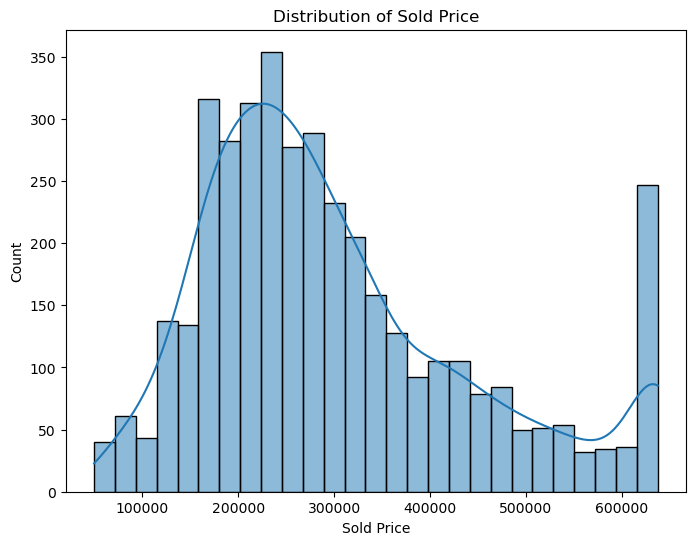

In [31]:
# Target variable analysis
plt.figure(figsize=(8, 6))
sns.histplot(housing_data['Sold Price'], kde=True)
plt.title('Distribution of Sold Price')
plt.show()

c:\Users\David\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


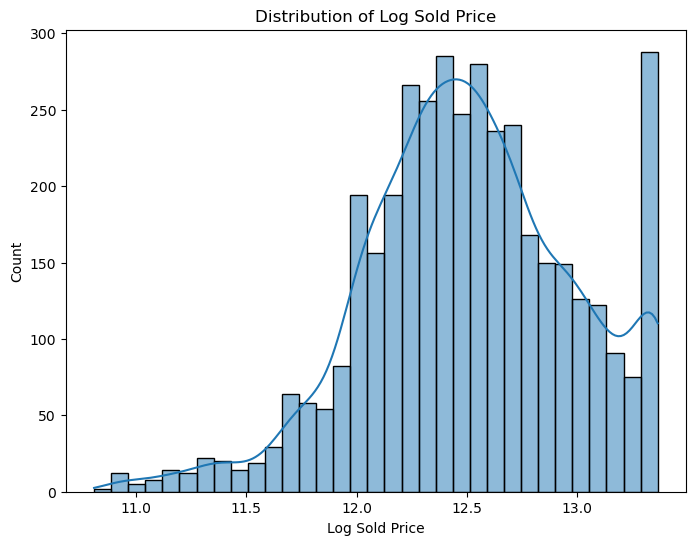

In [32]:
# Log transformation if skewed
housing_data['Log Sold Price'] = np.log1p(housing_data['Sold Price'])

plt.figure(figsize=(8, 6))
sns.histplot(housing_data['Log Sold Price'], kde=True)
plt.title('Distribution of Log Sold Price')
plt.show()

In [33]:
#Show all the values in the Sold Price column
housing_data['Sold Price']

0       197500.0
1       587702.0
2       543546.0
3       455904.0
4       125200.0
          ...   
3933    242000.0
3934    453000.0
3935    260000.0
3936    310000.0
3937    513000.0
Name: Sold Price, Length: 3938, dtype: float64

In [34]:
#Create a correlation matrix to see what the correlation is for Price per SqFt
corr_matrix = housing_data.corr()
corr_matrix["Sold Price"].sort_values(ascending=False)

Sold Price                   1.000000
List Price                   0.994766
Log Sold Price               0.956003
SqFt                         0.586477
Year Built                   0.383648
Total Baths                  0.296033
Days on Market               0.267721
Bedrooms                     0.182797
Mortgage Rates               0.175129
Closing Date                 0.167235
Closing Year                 0.159206
Lon                          0.128949
City_Raleigh                 0.103702
City_Saxapahaw               0.093837
City_Pittsboro               0.051895
Acres                        0.049462
List Year                    0.048827
City_Durham                  0.043726
List Date                    0.037403
City_Wake Forest             0.035489
Lat                          0.029884
City_Gibsonville             0.022231
City_Hillsborough            0.017376
Closing Month                0.015279
Zip                          0.014579
City_Fuquay Varina           0.004169
City_Cary   

In [35]:
# Save the DataFrame to a CSV file
housing_data.to_csv('Clean_Data/mls_condo_cleaned_3a.csv', index=False)